In [1]:
# !pip install compound-word-splitter

In [2]:
# !pip install pyenchant

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [4]:
import splitter
from tqdm import tqdm

In [5]:
tqdm.pandas(desc="Progress")

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Bidirectional, LSTM, Embedding, Dropout, SpatialDropout1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
# Load in preprocessed reviews
reviews = pd.read_csv("C:/Users/Kelvin Chumbe/Anaconda Projects/Hotel Review Mining/Preprocessed_Reviews.csv")

In [8]:
reviews.head()

,hotel,review,title,rating,date,month,year
0,Hilton London Tower Bridge,badly manage checkin process fresh orange juic...,catastrophic,1,2020-12-01,12,2020
1,Hilton London Tower Bridge,conference venued recently glance build nice i...,great decor average,1,2006-09-01,9,2006
2,Hilton London Tower Bridge,whilst new modern good many city destinations ...,let,1,2007-04-01,4,2007
3,Hilton London Tower Bridge,tower bridge days vacation fiance arrive airpo...,horrible management desk,1,2007-06-01,6,2007
4,Hilton London Tower Bridge,short hour plus work day look forward get some...,leave high dry support help,1,2009-05-01,5,2009


In [9]:
def compound_words(review):
    res_review = []
    
    for word in review.split(" "):
        word = splitter.split(word)
        for w in word:
            res_review.append(w)
        
    return ' '.join([word for word in res_review]) 

In [10]:
# reviews['review'] = reviews['review'].progress_apply(lambda x: compound_words(x))

In [11]:
# reviews['title'] = reviews['title'].progress_apply(lambda x: compound_words(str(x)))

In [13]:
# Save mapped tweets to file
# reviews.to_csv("Preprocessed_Uncompounded_Reviews.csv", index=False)

In [14]:
GLOVE_DIR = "C:/Users/Kelvin Chumbe/Downloads/Datasets/GloVe_archive"

In [15]:
# Create glove embeddings dict from glove file
glove_path = os.path.join(GLOVE_DIR, "glove.6B.50d.txt")
glove_embeddings= {}
EMBEDDING_DIM = 50

with open(glove_path, encoding='utf8') as file:
    for line in file:
        line = line.split()
        word = line[0]
        embedding = line[1:]

        glove_embeddings[word] = np.asarray(embedding, dtype='float32')

In [17]:
reviews['review'] = reviews['review'].apply(lambda x: str(x).split(" "))

In [18]:
# Tokenize and pad tweets
reviews_text = reviews['review']

print(reviews_text[:3])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews_text)
sequences = tokenizer.texts_to_sequences(reviews_text)

reviews_text = pad_sequences(sequences, maxlen=32, padding='post')

print(reviews_text[:3])

print('Found {} unique tokens.'.format(len(tokenizer.word_index)))

0    [badly, manage, checkin, process, fresh, orang...
1    [conference, venued, recently, glance, build, ...
2    [whilst, new, modern, good, many, city, destin...
Name: review, dtype: object
[[  744   572   124   677   431  1753  1414    69    94  5233   245  4162
   3822  1996  8363   251   697  2421  1721   412     4     2   223   172
     63     0     0     0     0     0     0     0]
 [ 1122   963    22  3231  1570   276  2811    41   810   200    57   341
    200   707   714   111  2019   944    56   810    49   959    22   215
   1754   392  1414 11776    43   242    19    22]
 [  230   407    49   222   172    32   153   542   452   209    39    33
   2379   517  2020    95   389    17   619  2422  2235     7   744    46
     71   246  1021  1617   483   461   415    40]]
Found 22696 unique tokens.


In [20]:
no_words = []

for word, i in tokenizer.word_index.items():
    if glove_embeddings.get(word) is None:
        no_words.append(word)
        
print(no_words)
print(len(no_words))

['housekeep', 'overprice', 'aircon', 'amys', 'appal', 'jamies', 'refurb', 'teacoffee', 'hadnt', 'bookingcom', 'werent', 'canapés', 'lgw', 'doubletrees', 'inroom', 'covid', 'helpfull', 'lastminutecom', 'prebooked', 'wifes', 'resturant', 'gatwicks', 'rollaway', 'barrestaurant', 'hhonours', 'refurbed', 'coffeetea', 'dilapidate', 'inout', 'checkedin', 'hotelscom', 'onoff', 'antiquate', 'tofrom', 'lastminute', 'roomthe', 'reccomend', 'barlounge', 'noisey', 'consierge', 'theyd', 'minifridge', 'restaraunt', 'discolour', 'roomservice', 'aircondition', 'onenight', 'bathshower', 'sheperds', 'matress', 'shouldnt', 'oclock', 'crossst', 'conceirge', 'disorganise', 'hotelthe', 'recomend', 'restaurantbar', 'wellequipped', 'whop', 'frontdesk', 'thth', 'welllocated', 'resturants', 'kingsized', 'tvcomputer', 'computertv', 'laterooms', 'hiltonhonors', 'dissapointing', 'discusting', 'checkingin', 'pleasent', 'matresses', 'weatherspoons', 'closeby', 'theyve', 'wellappointed', 'dissappointed', 'allinall', '

In [21]:
# # Create weight matrix
# embedding_matrix = np.random.random((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
# no_words = []

# for word, i in tokenizer.word_index.items():
#     embedding_vec = None

#     try: 
#         embedding_vec = word2vec_model[word]
#     except:
#         pass
    
#     if embedding_vec is not None:
#         embedding_matrix[i] = embedding_vec

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
label_enc = LabelEncoder()

reviews['rating'] = label_enc.fit_transform(reviews['rating'].values)

In [25]:
reviews.sample(5)

,hotel,review,title,rating,date,month,year
14799,DoubleTree by Hilton London - Westminster,"[wellpriced, locate, property, near, westminst...",interest,3,2012-09-01,9,2012
3434,Hilton London Tower Bridge,"[experience, number, issue, trip, use, honor, ...",catalogue errors,1,2020-08-01,8,2020
18494,Hilton London Metropole,"[start, five, star, chain, learn, hospitality,...",highly recommend great great,4,2018-07-01,7,2018
5430,DoubleTree by Hilton Hotel London - West End,"[dirty, poor, uncomfortable, useless, pillow, ...",disappoint,1,2017-06-01,6,2017
6317,Hilton London Metropole,"[th, birthday, deal, stay, though, im, honour,...",th birthday,1,2019-02-01,2,2019


In [26]:
n_classes = len(reviews['rating'].unique())

In [27]:
# Convert Categories to one-hot encoding
labels = to_categorical(reviews['rating'])

In [28]:
labels[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [29]:
reviews['rating'][:5]

0    0
1    0
2    0
3    0
4    0
Name: rating, dtype: int64

In [30]:
def reverseEncoded(labels):
    return np.argmax(labels, axis=1)

In [31]:
reverseEncoded(labels)[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [32]:
# # Build a Classification Model
# model = Sequential([
#     Embedding(len(tokenizer.word_index) + 1, 
#               EMBEDDING_DIM,
#               weights=[embedding_matrix],
#               input_length=50,
#               trainable=False),
# #     SpatialDropout1D(0.5),
#     Bidirectional(LSTM(100, return_sequences=True)),
# #     Dropout(0.5),
#     Bidirectional(LSTM(100, return_sequences=True)),
# #     Dropout(0.5),
#     Bidirectional(LSTM(200)),
#     Dropout(0.8),
    
#     Dense(512, activation='relu'),
#     Dropout(0.8),
#     Dense(512, activation='relu'),
#     Dropout(0.8),
#     Dense(n_classes, activation='softmax')
# ])


# model = Sequential()

# model.add(Embedding(len(tokenizer.word_index) + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=32,
#                             trainable=False))

# # model.add(SpatialDropout1D(0.8))
# model.add(Conv1D(32, kernel_size=3, activation="relu"))
# model.add(Flatten())
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.8))
# model.add(Dense(5, activation='softmax'))


model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 32))
model.add(GlobalMaxPooling1D())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(n_classes,activation='softmax'))


In [33]:
# sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
             
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.0001), 
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          726304    
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 727,525
Trainable params: 727,525
Non-trainable params: 0
_________________________________________________________________


In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# Split train and test data

train_X, test_X, train_Y, test_Y = train_test_split(reviews_text, labels, test_size=0.2, random_state=0, shuffle=True)

In [37]:
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((16302, 32), (4076, 32), (16302, 5), (4076, 5))

In [38]:
train_Y[:10]

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [39]:
filepath = "best_model.h5"

model_checkpoint = ModelCheckpoint(
    filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
)

In [40]:
EPOCHS = 400
BATCH_SIZE = 250

history = model.fit(train_X, train_Y, validation_split=0.8, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[model_checkpoint])

Epoch 1/400
14/14 [==============================] - 1s 51ms/step - loss: 1.6104 - accuracy: 0.2025 - val_loss: 1.6099 - val_accuracy: 0.2099
Epoch 2/400
14/14 [==============================] - 0s 28ms/step - loss: 1.6095 - accuracy: 0.1982 - val_loss: 1.6093 - val_accuracy: 0.2105
Epoch 3/400
14/14 [==============================] - 0s 18ms/step - loss: 1.6079 - accuracy: 0.2101 - val_loss: 1.6087 - val_accuracy: 0.2128
Epoch 4/400
14/14 [==============================] - 0s 16ms/step - loss: 1.6075 - accuracy: 0.2113 - val_loss: 1.6081 - val_accuracy: 0.2275
Epoch 5/400
14/14 [==============================] - 0s 27ms/step - loss: 1.6060 - accuracy: 0.2224 - val_loss: 1.6076 - val_accuracy: 0.2722
Epoch 6/400
14/14 [==============================] - 0s 30ms/step - loss: 1.6057 - accuracy: 0.2319 - val_loss: 1.6071 - val_accuracy: 0.2990
Epoch 7/400
14/14 [==============================] - 1s 44ms/step - loss: 1.6035 - accuracy: 0.2577 - val_loss: 1.6066 - val_accuracy: 0.2934
Epoch 

14/14 [==============================] - 0s 18ms/step - loss: 1.5352 - accuracy: 0.4227 - val_loss: 1.5604 - val_accuracy: 0.3617
Epoch 59/400
14/14 [==============================] - 1s 42ms/step - loss: 1.5302 - accuracy: 0.4344 - val_loss: 1.5582 - val_accuracy: 0.3630
Epoch 60/400
14/14 [==============================] - 0s 28ms/step - loss: 1.5279 - accuracy: 0.4261 - val_loss: 1.5560 - val_accuracy: 0.3615
Epoch 61/400
14/14 [==============================] - 0s 21ms/step - loss: 1.5276 - accuracy: 0.4120 - val_loss: 1.5539 - val_accuracy: 0.3622
Epoch 62/400
14/14 [==============================] - 0s 25ms/step - loss: 1.5214 - accuracy: 0.4368 - val_loss: 1.5516 - val_accuracy: 0.3642
Epoch 63/400
14/14 [==============================] - 0s 25ms/step - loss: 1.5191 - accuracy: 0.4334 - val_loss: 1.5494 - val_accuracy: 0.3659
Epoch 64/400
14/14 [==============================] - 0s 32ms/step - loss: 1.5152 - accuracy: 0.4362 - val_loss: 1.5471 - val_accuracy: 0.3665
Epoch 65/400

14/14 [==============================] - 0s 16ms/step - loss: 1.2522 - accuracy: 0.5270 - val_loss: 1.3677 - val_accuracy: 0.4059
Epoch 116/400
14/14 [==============================] - 0s 28ms/step - loss: 1.2437 - accuracy: 0.5334 - val_loss: 1.3642 - val_accuracy: 0.4061
Epoch 117/400
14/14 [==============================] - 0s 35ms/step - loss: 1.2417 - accuracy: 0.5399 - val_loss: 1.3609 - val_accuracy: 0.4074
Epoch 118/400
14/14 [==============================] - 1s 42ms/step - loss: 1.2345 - accuracy: 0.5362 - val_loss: 1.3577 - val_accuracy: 0.4070
Epoch 119/400
14/14 [==============================] - 1s 44ms/step - loss: 1.2316 - accuracy: 0.5390 - val_loss: 1.3544 - val_accuracy: 0.4069
Epoch 120/400
14/14 [==============================] - 1s 37ms/step - loss: 1.2272 - accuracy: 0.5285 - val_loss: 1.3511 - val_accuracy: 0.4071
Epoch 121/400
14/14 [==============================] - 1s 41ms/step - loss: 1.2177 - accuracy: 0.5534 - val_loss: 1.3478 - val_accuracy: 0.4073
Epoch 

Epoch 172/400
14/14 [==============================] - 0s 30ms/step - loss: 0.9905 - accuracy: 0.6298 - val_loss: 1.2335 - val_accuracy: 0.4323
Epoch 173/400
14/14 [==============================] - 0s 24ms/step - loss: 0.9888 - accuracy: 0.6307 - val_loss: 1.2318 - val_accuracy: 0.4328
Epoch 174/400
14/14 [==============================] - 0s 16ms/step - loss: 0.9836 - accuracy: 0.6325 - val_loss: 1.2305 - val_accuracy: 0.4339
Epoch 175/400
14/14 [==============================] - 0s 17ms/step - loss: 0.9762 - accuracy: 0.6288 - val_loss: 1.2291 - val_accuracy: 0.4339
Epoch 176/400
14/14 [==============================] - 0s 19ms/step - loss: 0.9749 - accuracy: 0.6429 - val_loss: 1.2277 - val_accuracy: 0.4334
Epoch 177/400
14/14 [==============================] - 0s 28ms/step - loss: 0.9691 - accuracy: 0.6383 - val_loss: 1.2265 - val_accuracy: 0.4332
Epoch 178/400
14/14 [==============================] - 0s 30ms/step - loss: 0.9698 - accuracy: 0.6448 - val_loss: 1.2252 - val_accuracy:

Epoch 229/400
14/14 [==============================] - 1s 45ms/step - loss: 0.7986 - accuracy: 0.7224 - val_loss: 1.1853 - val_accuracy: 0.4421
Epoch 230/400
14/14 [==============================] - 1s 42ms/step - loss: 0.7909 - accuracy: 0.7199 - val_loss: 1.1849 - val_accuracy: 0.4423
Epoch 231/400
14/14 [==============================] - 1s 42ms/step - loss: 0.7776 - accuracy: 0.7429 - val_loss: 1.1845 - val_accuracy: 0.4416
Epoch 232/400
14/14 [==============================] - 1s 45ms/step - loss: 0.7781 - accuracy: 0.7356 - val_loss: 1.1842 - val_accuracy: 0.4430
Epoch 233/400
14/14 [==============================] - 1s 36ms/step - loss: 0.7742 - accuracy: 0.7423 - val_loss: 1.1839 - val_accuracy: 0.4417
Epoch 234/400
14/14 [==============================] - 1s 41ms/step - loss: 0.7749 - accuracy: 0.7298 - val_loss: 1.1838 - val_accuracy: 0.4435
Epoch 235/400
14/14 [==============================] - 0s 20ms/step - loss: 0.7747 - accuracy: 0.7371 - val_loss: 1.1837 - val_accuracy:

Epoch 286/400
14/14 [==============================] - 1s 44ms/step - loss: 0.6154 - accuracy: 0.8353 - val_loss: 1.1802 - val_accuracy: 0.4455
Epoch 287/400
14/14 [==============================] - 1s 45ms/step - loss: 0.6171 - accuracy: 0.8236 - val_loss: 1.1803 - val_accuracy: 0.4463
Epoch 288/400
14/14 [==============================] - 1s 36ms/step - loss: 0.6041 - accuracy: 0.8328 - val_loss: 1.1805 - val_accuracy: 0.4459
Epoch 289/400
14/14 [==============================] - 1s 39ms/step - loss: 0.6045 - accuracy: 0.8331 - val_loss: 1.1809 - val_accuracy: 0.4456
Epoch 290/400
14/14 [==============================] - 0s 28ms/step - loss: 0.6084 - accuracy: 0.8248 - val_loss: 1.1811 - val_accuracy: 0.4462
Epoch 291/400
14/14 [==============================] - 0s 18ms/step - loss: 0.5969 - accuracy: 0.8356 - val_loss: 1.1814 - val_accuracy: 0.4463
Epoch 292/400
14/14 [==============================] - 0s 19ms/step - loss: 0.5911 - accuracy: 0.8313 - val_loss: 1.1816 - val_accuracy:

Epoch 343/400
14/14 [==============================] - 1s 45ms/step - loss: 0.4510 - accuracy: 0.8942 - val_loss: 1.2054 - val_accuracy: 0.4469
Epoch 344/400
14/14 [==============================] - 0s 33ms/step - loss: 0.4561 - accuracy: 0.8862 - val_loss: 1.2058 - val_accuracy: 0.4469
Epoch 345/400
14/14 [==============================] - 0s 26ms/step - loss: 0.4540 - accuracy: 0.8834 - val_loss: 1.2060 - val_accuracy: 0.4466
Epoch 346/400
14/14 [==============================] - 0s 19ms/step - loss: 0.4453 - accuracy: 0.8960 - val_loss: 1.2062 - val_accuracy: 0.4470
Epoch 347/400
14/14 [==============================] - 0s 18ms/step - loss: 0.4445 - accuracy: 0.8908 - val_loss: 1.2071 - val_accuracy: 0.4475
Epoch 348/400
14/14 [==============================] - 0s 23ms/step - loss: 0.4453 - accuracy: 0.8939 - val_loss: 1.2081 - val_accuracy: 0.4465
Epoch 349/400
14/14 [==============================] - 0s 29ms/step - loss: 0.4440 - accuracy: 0.8917 - val_loss: 1.2086 - val_accuracy:

14/14 [==============================] - 1s 43ms/step - loss: 0.3307 - accuracy: 0.9313 - val_loss: 1.2549 - val_accuracy: 0.4406
Epoch 400/400
14/14 [==============================] - 1s 40ms/step - loss: 0.3162 - accuracy: 0.9353 - val_loss: 1.2562 - val_accuracy: 0.4404


In [41]:
model = tf.keras.models.load_model(filepath)

In [42]:
loss, accuracy = model.evaluate(test_X, test_Y)
print("Loss: {:.2f}\nAccuracy: {:.2f}".format(loss, accuracy))

128/128 [==============================] - 0s 842us/step - loss: 1.2642 - accuracy: 0.4495
Loss: 1.2642165422439575
Accuracy: 0.4494602680206299


In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [51]:
# Use the model to make predictions
y_preds = model.predict(test_X)

# Generate classes from the one-hot encoded predictions
y_preds_classes = reverseEncoded(y_preds)

In [58]:
def visualizeReports(y_validation, y_preds_classes, labels, model_name):
    # Visualize the classification report so we can analyze accuracy, precision, recall and f1 score
    print("Classification Report for {} \n{} ".format(model_name, classification_report(reverseEncoded(y_validation), y_preds_classes, target_names=labels)))
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca()
    
    # Plot a confusion matrix of the predictions
    confusion_mx = confusion_matrix(reverseEncoded(y_validation), y_preds_classes)
    plt.title("Confusion Matrix for " + model_name)
    sns.heatmap(confusion_mx, xticklabels=labels, yticklabels=labels, annot=True, fmt=".0f", cmap=plt.cm.Blues, ax=ax)

In [59]:
# Define the class labels from the data
class_labels = ["1", "2", "3", "4", "5"]

Classification Report for Embedding Model 
              precision    recall  f1-score   support

           1       0.51      0.36      0.42       656
           2       0.39      0.46      0.43       869
           3       0.35      0.42      0.38       839
           4       0.45      0.42      0.43       871
           5       0.63      0.56      0.59       841

    accuracy                           0.45      4076
   macro avg       0.47      0.45      0.45      4076
weighted avg       0.46      0.45      0.45      4076
 


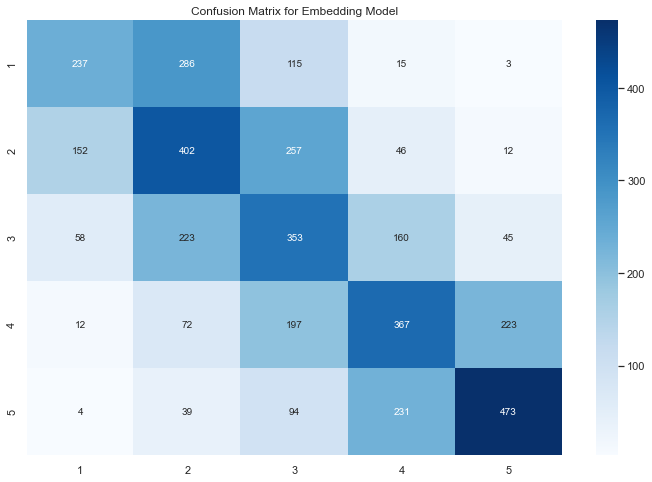

In [60]:
visualizeReports(test_Y, y_preds_classes, class_labels, "Embedding Model")